In [59]:
from src.dataset.gsdc_data_module import *
from src.modeling.gsdc_model import *
import joblib
import lightgbm as lgb
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from omegaconf import DictConfig
from sklearn import preprocessing

from src.dataset.kalman_filter import KF
from src.dataset.utils import *
from src.modeling.utils import *

In [60]:
conf = {}
conf['data_dir'] = '/Users/apple/Downloads/google-smartphone-decimeter-challenge'
conf['out_dir'] = '/Users/apple/Documents/code/iit/CS584/project/cs584_project/working/gsdc_train/out'
conf['model_dir'] = '/Users/apple/Documents/code/iit/CS584/project/cs584_project/working/gsdc_train/model'
ss = preprocessing.StandardScaler()

In [61]:
def pre_processing(dataset, is_need_fit=True):
    data_num = dataset[numerical_cols]
    cat_one_hot_1 = pd.get_dummies(dataset[[cat_cols[0]]].astype('str'))
    cat_one_hot_2 = pd.get_dummies(dataset[[cat_cols[1]]].astype('str'))
    cat_one_hot_3 = pd.get_dummies(dataset[[cat_cols[2]]].astype('str'))
    cat_one_hot_4 = pd.get_dummies(dataset[[cat_cols[3]]].astype('str'))
    cat_one_hot_5 = pd.get_dummies(dataset[[cat_cols[4]]].astype('str'))
    cat_one_hot_6 = pd.get_dummies(dataset[[cat_cols[5]]].astype('str'))
    cat_one_hot_7 = pd.get_dummies(dataset[[cat_cols[6]]].astype('str'))

    if is_need_fit:
        data_num = ss.fit_transform(data_num)
    else:
        data_num = ss.transform(data_num)

    return [data_num, cat_one_hot_1, cat_one_hot_2, cat_one_hot_3,
            cat_one_hot_4, cat_one_hot_5, cat_one_hot_6, cat_one_hot_7]

In [62]:
test_set = pd.read_csv(Path("/Users/apple/Documents/code/iit/CS584/project/cs584_project/working/gsdc_test/out/test_pd.csv"))
x_test = test_set[feature_cols]
test_input = pre_processing(x_test)

print('load all model param')
# load param
ann_model = create_nn_model(test_input[0].shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, 0)
ann_model.load_weights(conf['model_dir'] + '/ann_model.hdf5')
# self.ann_model.summary()

speed_mode = create_nn_model(test_input[0].shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, 0)
speed_mode.load_weights(conf['model_dir'] + '/speed_model.hdf5')
# self.speed_mode.summary()

train_data = pd.read_csv(Path(conf['out_dir']) / "train_pd.csv")
train_set, val_set = train_test_split(train_data, test_size=0.2)
x_tr = train_set[feature_cols]
y_tr = train_set[label_cols]
x_val = val_set[feature_cols]
y_val = val_set[label_cols]
xtr_input = pre_processing(x_tr)
xval_input = pre_processing(x_val, False)

load all model param


In [63]:
lgb_train = lgb.Dataset(x_tr, train_set['dis_lat'])
lgb_eval = lgb.Dataset(x_val, val_set['dis_lat'], reference=lgb_train)
result = {}
params = {
            'objective': 'regression_l1',
            'max_bin': 600,
            'learning_rate': 0.01,
            'num_leaves': 80
        }
model_lat = lgb.train(params, lgb_train,
                            valid_sets=[lgb_train, lgb_eval],
                            verbose_eval=25,
                            num_boost_round=10000,
                            evals_result=result,
                            early_stopping_rounds=10
                            )

/Users/apple/.conda/envs/GSDC/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/Users/apple/.conda/envs/GSDC/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/Users/apple/.conda/envs/GSDC/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44061
[LightGBM] [Info] Number of data points in the train set: 98626, number of used features: 83
[LightGBM] [Info] Start training from score 0.000004
Training until validation scores don't improve for 10 rounds
[25]	training's l1: 1.35523e-05	valid_1's l1: 1.34623e-05
[50]	training's l1: 1.2732e-05	valid_1's l1: 1.26786e-05
[75]	training's l1: 1.20866e-05	valid_1's l1: 1.20621e-05
[100]	training's l1: 1.15681e-05	valid_1's l1: 1.15671e-05
[125]	training's l1: 1.11785e-05	valid_1's l1: 1.11949e-05
[150]	training's l1: 1.08486e-05	valid_1's l1: 1.08873e-05
[175]	training's l1: 1.05415e-05	valid_1's l1: 1.06022e-05
[200]	training's l1: 1.02862e-05	valid_1's l1: 1.03659e-05
[225]	training's l1: 1.00673e-05	valid_1's l1: 1.01656e-05
[250]	training's l1: 9.87971e-06	valid_1's l1: 9.99555e-06
[275]	t

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

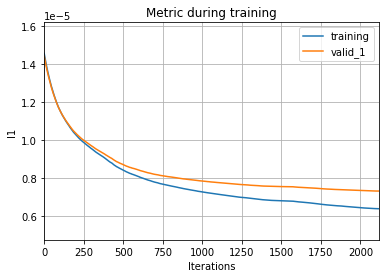

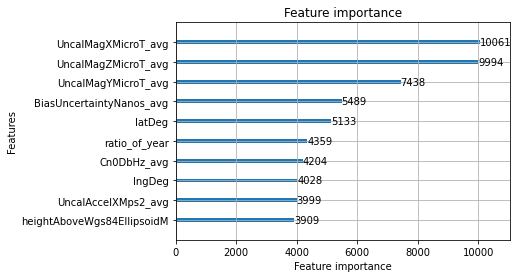

In [64]:
lgb.plot_metric(result)

lgb.plot_importance(model_lat,max_num_features=10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44061
[LightGBM] [Info] Number of data points in the train set: 98626, number of used features: 83
[LightGBM] [Info] Start training from score -0.000001
Training until validation scores don't improve for 10 rounds
[25]	training's l1: 1.68413e-05	valid_1's l1: 1.6774e-05
[50]	training's l1: 1.56353e-05	valid_1's l1: 1.55996e-05
[75]	training's l1: 1.46744e-05	valid_1's l1: 1.46738e-05
[100]	training's l1: 1.39064e-05	valid_1's l1: 1.39475e-05
[125]	training's l1: 1.3321e-05	valid_1's l1: 1.33925e-05
[150]	training's l1: 1.28442e-05	valid_1's l1: 1.29411e-05
[175]	training's l1: 1.24614e-05	valid_1's l1: 1.25813e-05
[200]	training's l1: 1.21397e-05	valid_1's l1: 1.2282e-05
[225]	training's l1: 1.18915e-05	valid_1's l1: 1.20555e-05
[250]	training's l1: 1.16739e-05	valid_1's l1: 1.18586e-05
[275]	tr

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

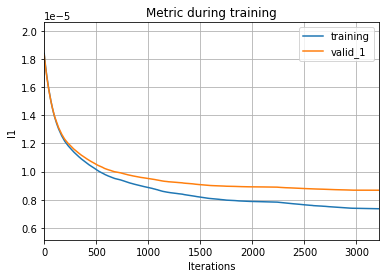

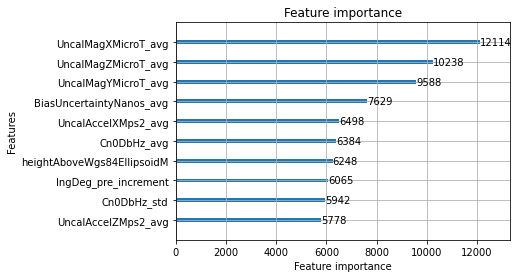

In [65]:
lgb_train = lgb.Dataset(x_tr, train_set['dis_lng'])
lgb_eval = lgb.Dataset(x_val, val_set['dis_lng'], reference=lgb_train)
model_lng = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=25,
    num_boost_round=10000,
    evals_result=result,
    early_stopping_rounds=10
)
lgb.plot_metric(result)
lgb.plot_importance(model_lng, max_num_features=10)

In [70]:
import plotly.express as px
def visualize_trafic(df, center, zoom=15):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df):
    target_df = df
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)


In [84]:
# Visualization: Val dataset
# GT
tmp1 = val_set[['latDeg_truth', 'lngDeg_truth']].copy()
tmp1.rename(columns={'latDeg_truth':'latDeg', 'lngDeg_truth':'lngDeg'}, inplace=True)
tmp1['phoneName'] = ['_truth' for i in range(len(tmp1))]
# Baseline
tmp2 = val_set[['latDeg', 'lngDeg']].copy()
tmp1.rename(columns={'latDeg':'latDeg', 'lngDeg':'lngDeg'}, inplace=True)
tmp2['phoneName'] = ['_pred' for i in range(len(tmp2))]

tmp = pd.concat([tmp1, tmp2])
visualize_collection(tmp)